Simulating training dataset ...
Training data shape: (50000, 3)
Training MDN model (with N as input) ...
Epoch 10/80, Loss = 0.44999
Epoch 20/80, Loss = 0.42586
Epoch 30/80, Loss = 0.41378
Epoch 40/80, Loss = 0.41001
Epoch 50/80, Loss = 0.41074
Epoch 60/80, Loss = 0.40843
Epoch 70/80, Loss = 0.40748
Epoch 80/80, Loss = 0.39971
MDN training complete.
N=220, y=40 has too few samples (15), skipping.
N=220, y=60 has too few samples (8), skipping.
N=220, y=80 has too few samples (15), skipping.
N=280, y=40 has too few samples (12), skipping.
N=280, y=60 has too few samples (10), skipping.
N=280, y=80 has too few samples (5), skipping.


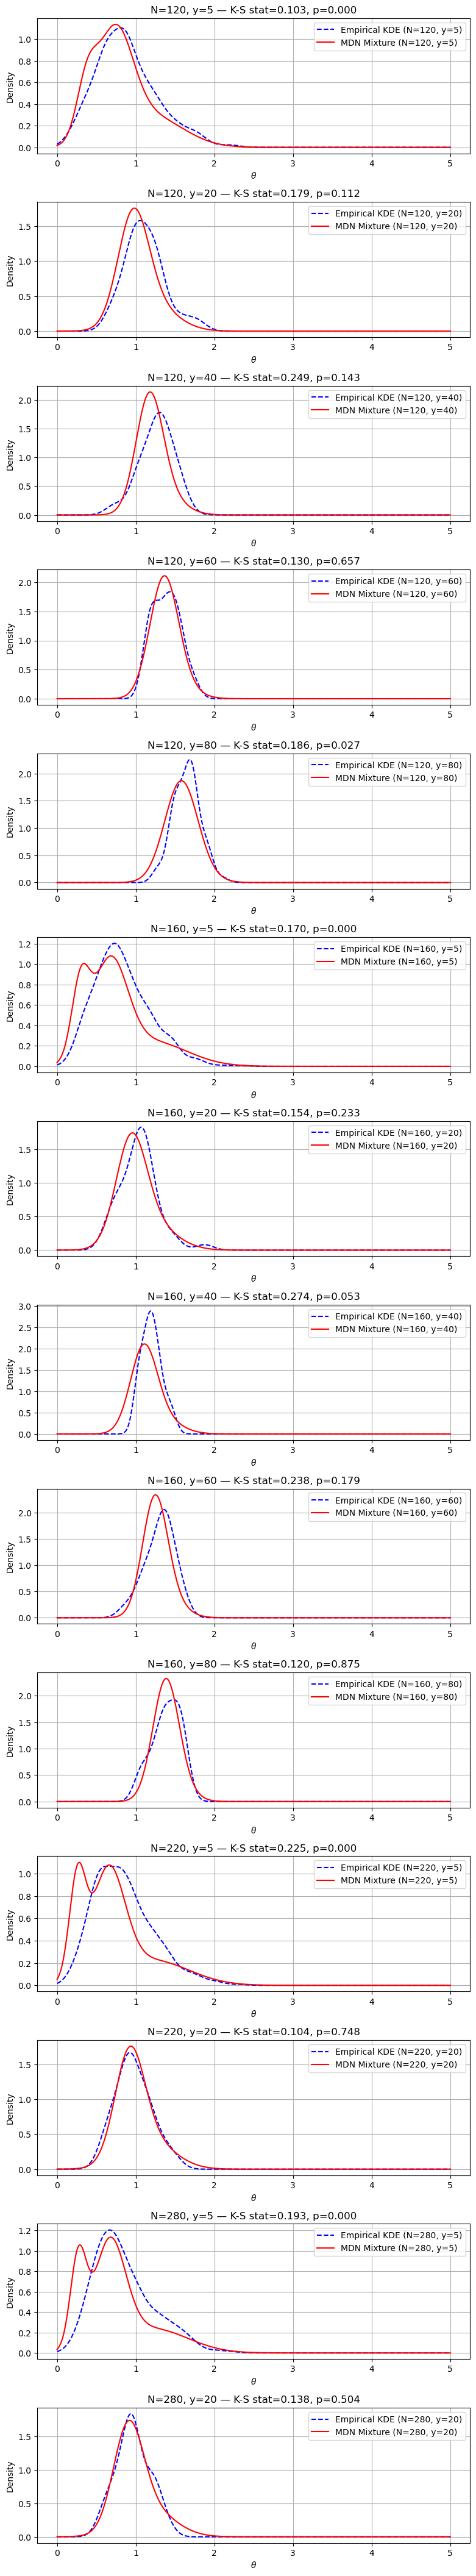


K-S Test Results (Unseen N):
N=120, y=5: KS_stat=0.1033, p-value=0.0003
N=120, y=20: KS_stat=0.1789, p-value=0.1119
N=120, y=40: KS_stat=0.2495, p-value=0.1432
N=120, y=60: KS_stat=0.1295, p-value=0.6573
N=120, y=80: KS_stat=0.1861, p-value=0.0269
N=160, y=5: KS_stat=0.1699, p-value=0.0000
N=160, y=20: KS_stat=0.1541, p-value=0.2325
N=160, y=40: KS_stat=0.2740, p-value=0.0534
N=160, y=60: KS_stat=0.2385, p-value=0.1789
N=160, y=80: KS_stat=0.1201, p-value=0.8751
N=220, y=5: KS_stat=0.2249, p-value=0.0000
N=220, y=20: KS_stat=0.1045, p-value=0.7478
N=280, y=5: KS_stat=0.1927, p-value=0.0000
N=280, y=20: KS_stat=0.1379, p-value=0.5044


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from scipy.stats import norm, gaussian_kde
from scipy.special import logsumexp
from scipy.stats import ks_2samp

# 1. SIR model simulation: given N, lam, k, return final infected count y
def SIR_sim(N, lam, k):
    S = N - 1
    y = 1
    while y > 0:
        y -= 1
        I = 1 if k == 0 else np.random.gamma(shape=k, scale=1 / k)
        Z = np.random.poisson(lam * I)
        for _ in range(Z):
            if np.random.rand() < S / N:
                S -= 1
                y += 1
    return N - S

# 2. Data simulation: simulate M samples of (theta, y, N)
#    theta ~ Exponential(1), N randomly drawn from N_values_train
#    y = SIR_sim(N, theta, k)
def simulate_theta_y_N_pairs(M=20000, N_values=None, k=0, lam_scale=1.0):
    """
    Returns a NumPy array of shape (M,3) with columns [theta, y, N].
    N_values: list, e.g., [50,75,100,125,150]
    lam_scale: set to scale if lam ~ Exponential(scale), otherwise lam = theta
    """
    data = np.zeros((M, 3), dtype=np.float32)
    for m in range(M):
        N = int(np.random.choice(N_values))
        theta = np.random.exponential(1.0)
        y = SIR_sim(N, theta, k)
        data[m, 0] = theta
        data[m, 1] = float(y)
        data[m, 2] = float(N)
    return data

# 3. Define MDN network: input (y/N, log(N)), output parameters of K Gaussian components

class PosteriorMDN_N(nn.Module):
    def __init__(self, num_components=3):
        super(PosteriorMDN_N, self).__init__()
        self.K = num_components
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 64)
        # Output layer: K pi_logits + K mu + K log_sigma
        self.out = nn.Linear(64, self.K * 3)

    def forward(self, inputs):
        x = torch.relu(self.fc1(inputs))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        output = self.out(x)  # [batch, 3*K]
        pi_logits  = output[:, 0 : self.K]
        mu         = output[:,     self.K : 2*self.K]
        log_sigma  = output[:, 2*self.K : 3*self.K]
        return pi_logits, mu, log_sigma

# 4. MDN loss function: Negative log-likelihood for Gaussian mixture
def mdn_loss(theta_true, pi_logits, mu, log_sigma):
    if theta_true.dim() == 1:
        theta_true = theta_true.unsqueeze(1)  # [batch,1]
    sigma = torch.exp(log_sigma)
    pi = torch.softmax(pi_logits, dim=1)

    const = 0.5 * np.log(2 * np.pi)
    theta_expanded = theta_true.expand(-1, mu.size(1))  # [batch, K]
    log_prob_each = -const - log_sigma - 0.5 * ((theta_expanded - mu) / sigma) ** 2

    log_pi = torch.log(pi + 1e-12)  # prevent log(0)
    weighted_log_prob = log_pi + log_prob_each
    log_sum_exp = torch.logsumexp(weighted_log_prob, dim=1)

    nll = -torch.mean(log_sum_exp)
    return nll

# 5. Train MDN model
def train_mdn_model_N(data, num_epochs=100, batch_size=256, lr=1e-3, num_components=3):
    thetas = torch.from_numpy(data[:, 0].astype(np.float32))
    ys     = data[:, 1:2]
    Ns     = data[:, 2:3]

    y_norm = torch.from_numpy((ys / Ns).astype(np.float32))
    log_N  = torch.from_numpy(np.log(Ns).astype(np.float32))

    inputs = torch.cat([y_norm, log_N], dim=1)
    dataset = torch.utils.data.TensorDataset(inputs, thetas)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    model = PosteriorMDN_N(num_components=num_components)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_inputs, batch_theta in dataloader:
            optimizer.zero_grad()
            pi_logits, mu, log_sigma = model(batch_inputs)
            loss = mdn_loss(batch_theta, pi_logits, mu, log_sigma)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_theta.size(0)
        epoch_loss /= len(dataset)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss = {epoch_loss:.5f}")
    return model

# 6. Visualization & K-S test: for unseen N and given y, compare MDN vs empirical KDE
def plot_mdn_posterior_vs_kde_N(model, N_values_unseen, y_values_test, num_simulate=20000, 
                                 theta_range=(0,5), num_theta_points=500):
    """
    For each unseen N and y in y_values_test:
    - Simulate many (theta,y) pairs with fixed N
    - Estimate posterior using KDE and compare with MDN prediction
    - Use K-S test to compare samples
    """
    theta_points = np.linspace(theta_range[0], theta_range[1], num_theta_points)
    ks_results = []

    total_plots = len(N_values_unseen) * len(y_values_test)
    plt.figure(figsize=(8, 3 * total_plots))

    plot_idx = 1
    for N in N_values_unseen:
        data_unseen = simulate_theta_y_N_pairs(M=num_simulate, N_values=[N], k=0)
        for y_obs in y_values_test:
            mask = data_unseen[:, 1] == y_obs
            theta_samples_true = data_unseen[mask, 0]
            if len(theta_samples_true) < 20:
                print(f"N={N}, y={y_obs} has too few samples ({len(theta_samples_true)}), skipping.")
                continue

            kde = gaussian_kde(theta_samples_true)
            kde_vals = kde(theta_points)

            y_norm = torch.tensor([[y_obs / N]], dtype=torch.float32)
            log_N_input = torch.tensor([[np.log(N)]], dtype=torch.float32)
            inputs = torch.cat([y_norm, log_N_input], dim=1)
            with torch.no_grad():
                pi_logits, mu, log_sigma = model(inputs)
            pi_logits = pi_logits.numpy().reshape(-1)
            mu        = mu.numpy().reshape(-1)
            log_sigma = log_sigma.numpy().reshape(-1)
            pi = np.exp(pi_logits - logsumexp(pi_logits))
            sigma = np.exp(log_sigma)

            mdn_pdf = np.zeros_like(theta_points)
            for k in range(model.K):
                mdn_pdf += pi[k] * norm.pdf(theta_points, loc=mu[k], scale=sigma[k])

            num_samples = 2000
            comp_choices = np.random.choice(model.K, size=num_samples, p=pi)
            theta_samples_mdn = np.zeros(num_samples, dtype=np.float32)
            for i in range(num_samples):
                k = comp_choices[i]
                theta_samples_mdn[i] = np.random.normal(loc=mu[k], scale=sigma[k])
                if theta_samples_mdn[i] < 0:
                    theta_samples_mdn[i] = 0.0

            ks_stat, p_value = ks_2samp(theta_samples_true, theta_samples_mdn)
            ks_results.append((N, y_obs, ks_stat, p_value))

            ax = plt.subplot(total_plots, 1, plot_idx)
            ax.plot(theta_points, kde_vals, linestyle='dashed', color='blue',
                    label=f'Empirical KDE (N={N}, y={y_obs})')
            ax.plot(theta_points, mdn_pdf, color='red',
                    label=f'MDN Mixture (N={N}, y={y_obs})')
            ax.set_title(f'N={N}, y={y_obs} — K-S stat={ks_stat:.3f}, p={p_value:.3f}')
            ax.set_xlabel(r'$\theta$')
            ax.set_ylabel('Density')
            ax.legend()
            ax.grid(True)
            plot_idx += 1

    plt.tight_layout()
    plt.show()

    print("\nK-S Test Results (Unseen N):")
    for (N, y_obs, ks_stat, p_value) in ks_results:
        print(f"N={N}, y={y_obs}: KS_stat={ks_stat:.4f}, p-value={p_value:.4f}")

# 7. Main program: train and test
if __name__ == "__main__":
    N_values_train = [50, 75, 100, 125, 150]
    N_values_unseen = [120, 160, 220, 280]
    y_values_test = [5, 20, 40, 60, 80]

    M_train = 50000
    print("Simulating training dataset ...")
    data_train = simulate_theta_y_N_pairs(M=M_train, N_values=N_values_train, k=0)
    print(f"Training data shape: {data_train.shape}")

    print("Training MDN model (with N as input) ...")
    num_epochs = 80
    batch_size = 256
    learning_rate = 1e-3
    num_components = 3
    model = train_mdn_model_N(data_train,
                              num_epochs=num_epochs,
                              batch_size=batch_size,
                              lr=learning_rate,
                              num_components=num_components)
    print("MDN training complete.")

    plot_mdn_posterior_vs_kde_N(model, N_values_unseen, y_values_test,
                                num_simulate=30000,
                                theta_range=(0, 5),
                                num_theta_points=500)

In [3]:
pip install --upgrade torch torchvision torchaudio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 25.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


Simulating training dataset ...
Training data shape: (50000, 3)
Training MDN model (with N as input) ...
Epoch 10/80, Loss = 0.29325
Epoch 20/80, Loss = 0.24295
Epoch 30/80, Loss = 0.23058
Epoch 40/80, Loss = 0.22453
Epoch 50/80, Loss = 0.20283
Epoch 60/80, Loss = 0.18571
Epoch 70/80, Loss = 0.17510
Epoch 80/80, Loss = 0.16931
MDN training complete.
N=1200, y=200 has too few samples (7), skipping.
N=1600, y=200 has too few samples (6), skipping.
N=1600, y=400 has too few samples (8), skipping.
N=1600, y=600 has too few samples (19), skipping.
N=2200, y=200 has too few samples (5), skipping.
N=2200, y=400 has too few samples (8), skipping.
N=2200, y=600 has too few samples (11), skipping.
N=2200, y=800 has too few samples (9), skipping.
N=2800, y=200 has too few samples (3), skipping.
N=2800, y=400 has too few samples (3), skipping.
N=2800, y=600 has too few samples (5), skipping.
N=2800, y=800 has too few samples (5), skipping.


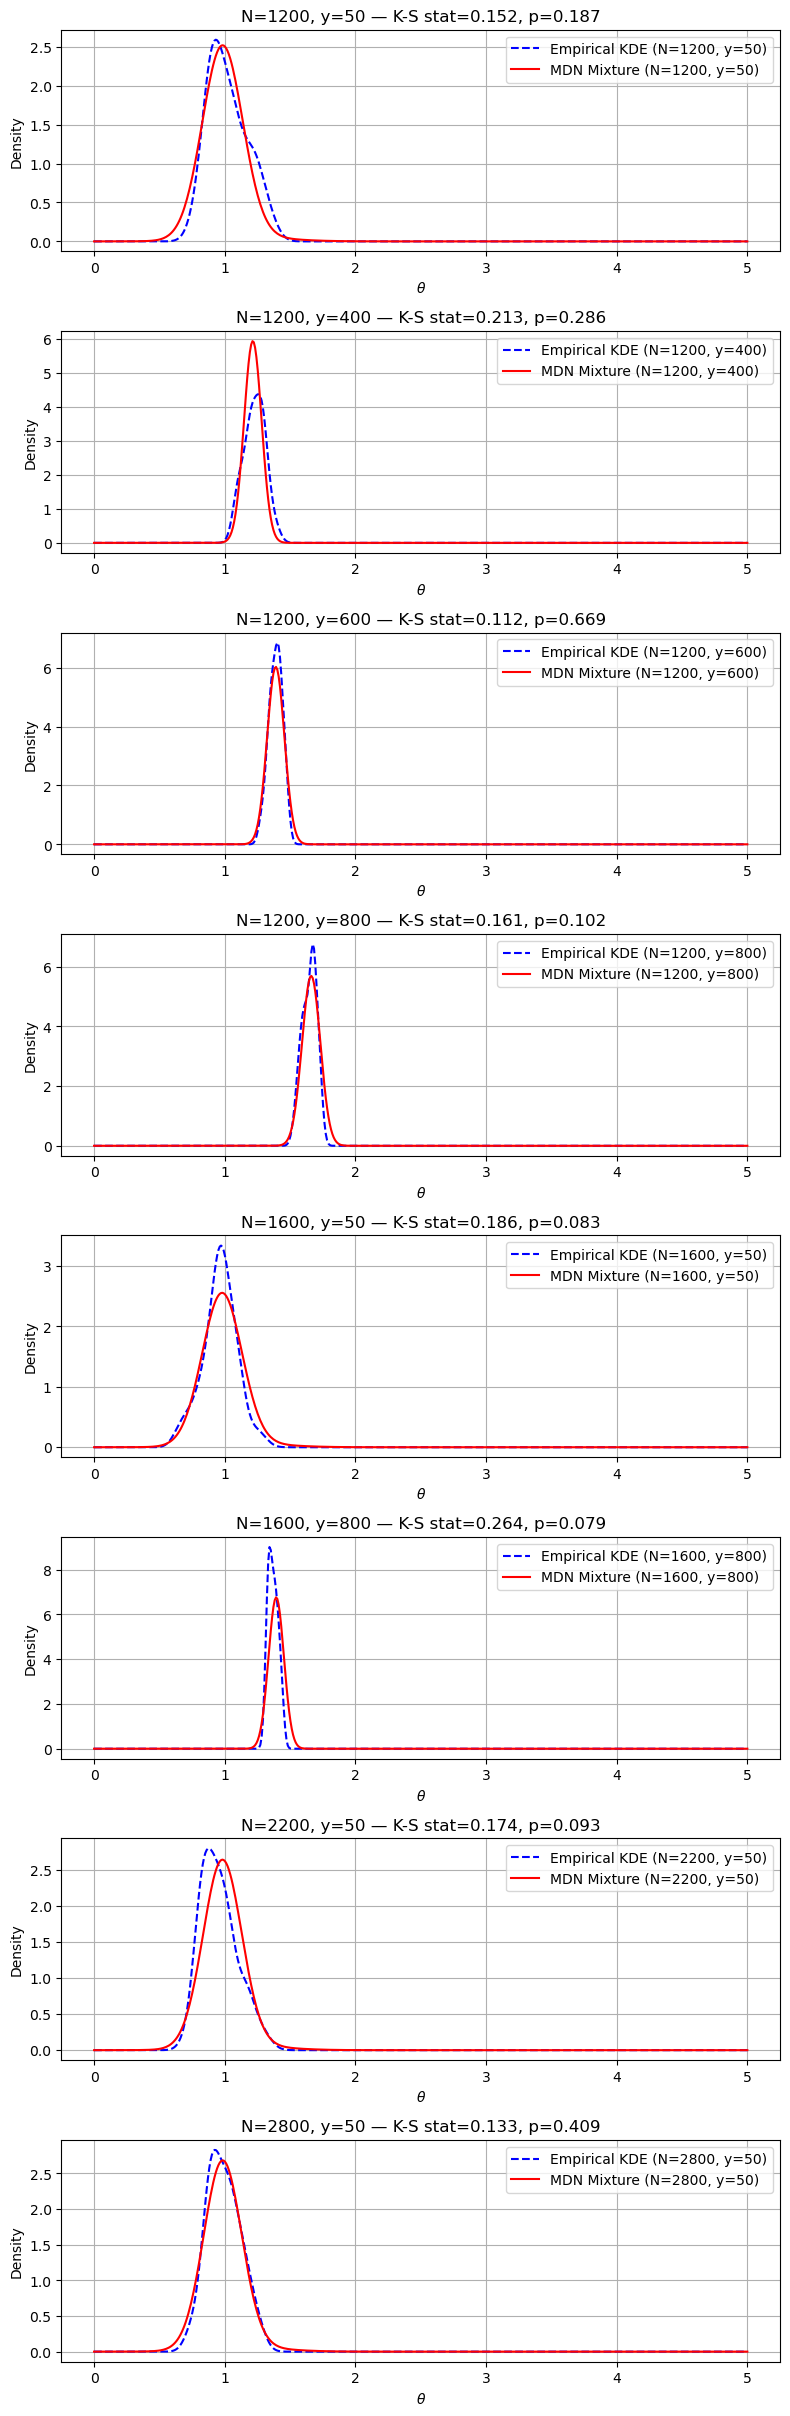


K-S Test Results (Unseen N):
N=1200, y=50: KS_stat=0.1525, p-value=0.1874
N=1200, y=400: KS_stat=0.2135, p-value=0.2857
N=1200, y=600: KS_stat=0.1120, p-value=0.6693
N=1200, y=800: KS_stat=0.1607, p-value=0.1019
N=1600, y=50: KS_stat=0.1861, p-value=0.0830
N=1600, y=800: KS_stat=0.2642, p-value=0.0787
N=2200, y=50: KS_stat=0.1740, p-value=0.0928
N=2800, y=50: KS_stat=0.1330, p-value=0.4093


In [3]:
if __name__ == "__main__":
    N_values_train = [500, 750, 1000, 1250, 1500]
    N_values_unseen = [1200, 1600, 2200, 2800]
    y_values_test = [50, 200, 400, 600, 800]

    M_train = 50000
    print("Simulating training dataset ...")
    data_train = simulate_theta_y_N_pairs(M=M_train, N_values=N_values_train, k=0)
    print(f"Training data shape: {data_train.shape}")

    print("Training MDN model (with N as input) ...")
    num_epochs = 80
    batch_size = 256
    learning_rate = 1e-3
    num_components = 3
    model = train_mdn_model_N(data_train,
                              num_epochs=num_epochs,
                              batch_size=batch_size,
                              lr=learning_rate,
                              num_components=num_components)
    print("MDN training complete.")

    plot_mdn_posterior_vs_kde_N(model, N_values_unseen, y_values_test,
                                num_simulate=300000,
                                theta_range=(0, 5),
                                num_theta_points=500)